## Import and download datasets

In [1]:
import kagglehub

# Download the latest dataset version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)

Path to dataset files: C:\Users\tienn\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


## Import libraries

In [2]:
import os
import torch
import random
import numpy as np

import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches
import xml.etree.ElementTree as ET
import tqdm.notebook as tqdm

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights
from torchmetrics.detection import MeanAveragePrecision
from torch.cuda.amp import GradScaler, autocast

## Dataset Class with Bouding box Definition

In [3]:
class MyDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None

        for obj in root.findall("object"):
            name = obj.find("name").text
            if label is None:  # Take the first label
                label = name

                # Get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]
    
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # print(f"Getting item at index {idx}")
        
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)
        # print(f"Loading first image from {img1_path}")
        
        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        # print(f"Loading first annotation from {annotation_name}")
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        if idx == len(self.image_files) - 1:
            idx2 = 0
        else:
            idx2 = idx + 1
            
        # print(f"Second image index: {idx2}")

        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)
        # print(f"Loading second image from {img2_path}")
        
        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        # print(f"Loading second annotation from {annotation_name}")
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        
        # print(f"Image sizes - img1: {img1.size}, img2: {img2.size}")

        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        
        # print(f"Merged image size: {merged_image.size}")

        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # Adjust bbox coordinates for objects from img1 AND normalize
        new_bbox1 = [
            img1_annotations[1][0] * img1.width / merged_w,  # Normalize xmin
            img1_annotations[1][1] * img1.height / merged_h,  # Normalize ymin
            img1_annotations[1][2] * img1.width / merged_w,  # Normalize xmax
            img1_annotations[1][3] * img1.height / merged_h,  # Normalize ymax
        ]
        
        # print(f"First bbox normalized coordinates: {new_bbox1}")

        merged_annotations.append({"bbox": new_bbox1, "label": img1_annotations[0]})

        # Adjust bbox coordinates for objects from img2 AND normalize
        new_bbox2 = [
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,  # Normalize xmin
            img2_annotations[1][1] * img2.height / merged_h,                # Normalize ymin
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,  # Normalize xmax
            img2_annotations[1][3] * img2.height / merged_h,                # Normalize ymax
        ]
        
        # print(f"Second bbox normalized coordinates: {new_bbox2}")

        merged_annotations.append({"bbox": new_bbox2, "label": img2_annotations[0]})

        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
            # print("Applied custom transform to merged image")
        else:
            merged_image = transforms.ToTensor()(merged_image)
            # print("Applied default ToTensor transform to merged image")

        # Convert annotations to 1D tensors, with shape (4,) for bbox and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))

        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat(
                (torch.tensor(ann["bbox"]), torch.tensor([ann["label"]]))
            )
            
        # print(f"Final annotations tensor shape: {annotations.shape}")

        return merged_image, annotations

## Data Analysis and Preparation

In [4]:
# Define paths
annotations_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# First create two base datasets with different transforms
base_dataset = MyDataset(annotations_dir, image_dir, transform=transform)

# Get the total dataset size
dataset_size = len(base_dataset)

# Calculate train and validation sizes
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

# Generate indices
indices = np.arange(dataset_size)
np.random.seed(42)  # Ensure reproducibility
np.random.shuffle(indices)

# Split indices for train and validation sets
train_indices, val_indices = indices[:train_size], indices[train_size:]
# train_indices, val_indices = indices[:1], indices[1:] # This line is commented out in the image

# Create Subsets using the appropriate base dataset
train_dataset = Subset(base_dataset, train_indices)
val_dataset = Subset(base_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    # num_workers=4,
    # persistent_workers=True,
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    pin_memory=True,
    # num_workers=4,
    # persistent_workers=True,
    drop_last=False,
)

# Initialize model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {"dog": 0, "cat": 1}

## Build model

In [5]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(2048, 2 * 2 * (4 + self.num_classes))  # 2 is for the number of grid cell
        
    @torch.autocast(device_type='cuda', dtype=torch.float)
    def forward(self, x):  # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [6]:
# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # Assuming two classes: dog and cat

class_to_idx = {'dog': 0, 'cat': 1}

model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Functions definition

#### Calculate Loss

In [7]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(batch_size, 2, 2, 4 + num_classes)  # Reshape to (batch_size, grid_y, grid_x, 4 + num_classes)

    for i in range(batch_size):  # Iterate through each image in the batch
        grid_have_object = torch.zeros((batch_size, 2, 2), device=device)

        for j in range(len(targets[i])):  # Iterate through objects in the image
            # Determine which grid cell the object's center falls into
            # Assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2)  # Multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            grid_have_object[i, grid_y, grid_x] = 1

            # 1. Classification Loss for the responsible grid cell
            # Convert label to one-hot encoding only for this example
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # Classification loss (using CrossEntropyLoss)
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. Regression Loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device) #Fixed indexing
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target) 

            # import pdb; pdb.set_trace()

            total_loss += classification_loss + regression_loss

            # 3. No Object Loss (for other grid cells)
            no_obj_loss = 0

            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if grid_have_object[i, other_grid_y, other_grid_x] == 0:
                        # MSE loss for predicting no object (all zeros)
                        no_obj_loss += mse_loss(
                            output[i, other_grid_y, other_grid_x, :4],
                            torch.zeros(4, device=device)
                        )

            total_loss += classification_loss + regression_loss + no_obj_loss
            # total_loss += no_obj_loss

    return total_loss/batch_size


#### Calculate IoU

In [8]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x_a = max(box1[0], box2[0])
    y_a = max(box1[1], box2[1])
    x_b = min(box1[2], box2[2])
    y_b = min(box1[3], box2[3])

    # Compute the area of intersection
    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # Compute the area of both the prediction and ground-truth
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the IoU
    iou = inter_area / float(box1_area + box2_area - inter_area)

    return iou

#### Evaluate Model

In [9]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device, non_blocking=True)

            output = model(images)
            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)
            
            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Convert predictions and targets to the format required by MeanAveragePrecision
            for batch_idx in range(images.shape[0]):
                preds = []
                targs = []

                # Process ground truth targets
                for target in targets[batch_idx]:
                    targs.append({
                        "boxes": target[:4].unsqueeze(0),
                        "labels": target[4].unsqueeze(0).long()  # Convert label to Long
                    })

                # Match predictions to ground truth targets based on highest IoU
                # Iterate through targets first to find the best matching prediction for each target
                for target_idx, target in enumerate(targets[batch_idx]):
                    best_iou = -1
                    best_pred_idx = -1
                    for grid_y in range(2):
                        for grid_x in range(2):
                            # Extract predicted bounding box
                            bbox_pred = output[batch_idx, grid_y, grid_x, :4]

                            # Skip predictions where bbox is approximately [0, 0, 0, 0]
                            if torch.all(torch.round(bbox_pred, decimals=2) == 0):
                                continue

                            # Calculate IoU with the current target
                            iou = calculate_iou(bbox_pred, target[:4])

                            # If this prediction has higher IoU than current best, update
                            if iou > best_iou:
                                best_iou = iou
                                best_pred_idx = (grid_y, grid_x)
                    # If a best match is found for this target, add the prediction
                    if best_pred_idx != -1:
                        grid_y, grid_x = best_pred_idx
                        bbox_pred = output[batch_idx, grid_y, grid_x, :4]
                        class_probs = torch.softmax(output[batch_idx, grid_y, grid_x, 4:], dim=0)
                        class_pred = class_probs.argmax().item()
                        confidence = class_probs[class_pred].item()

                        preds.append({
                            "boxes": bbox_pred.unsqueeze(0),
                            "scores": torch.tensor([confidence], device=device),
                            "labels": torch.tensor([class_pred], device=device),
                        })

                # Add current batch predictions and targets to the overall lists
                if preds:  # Only add to all_preds if there are any valid predictions
                    all_preds.append({
                        k: v.to(device) if isinstance(v, torch.Tensor) else v
                        for k, v in preds[0].items()
                    })

                if targs:
                    all_targets.append({
                        k: v.to(device) if isinstance(v, torch.Tensor) else v
                        for k, v in targs[0].items()
                    })

    val_loss = running_loss / len(data_loader)

    # Calculate mAP
    metric = MeanAveragePrecision()
    metric.update(all_preds, all_targets)
    mAP_dict = metric.compute()

    return val_loss, mAP_dict["map"]

#### Train Model

In [10]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes):
    best_val_map = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    

    for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm.tqdm(train_loader, desc="Batches", leave=False):
            batch_size = images.shape[0]
            images = images.to(device, non_blocking=True) #Added non_blocking for performance

            optimizer.zero_grad()
            output = model(images)

            output = output.view(batch_size, 2, 2, 4 + num_classes)
            total_loss = calculate_loss(output, targets, device, num_classes)

            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation
        val_loss, val_map = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_map)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, "
            f"Validation Loss: {val_loss:.4f}, Validation mAP: {val_map:.4f}"
        )

        # Save the best model
        if val_map > best_val_map:
            best_val_map = val_map
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

#### Visualize Data Samples

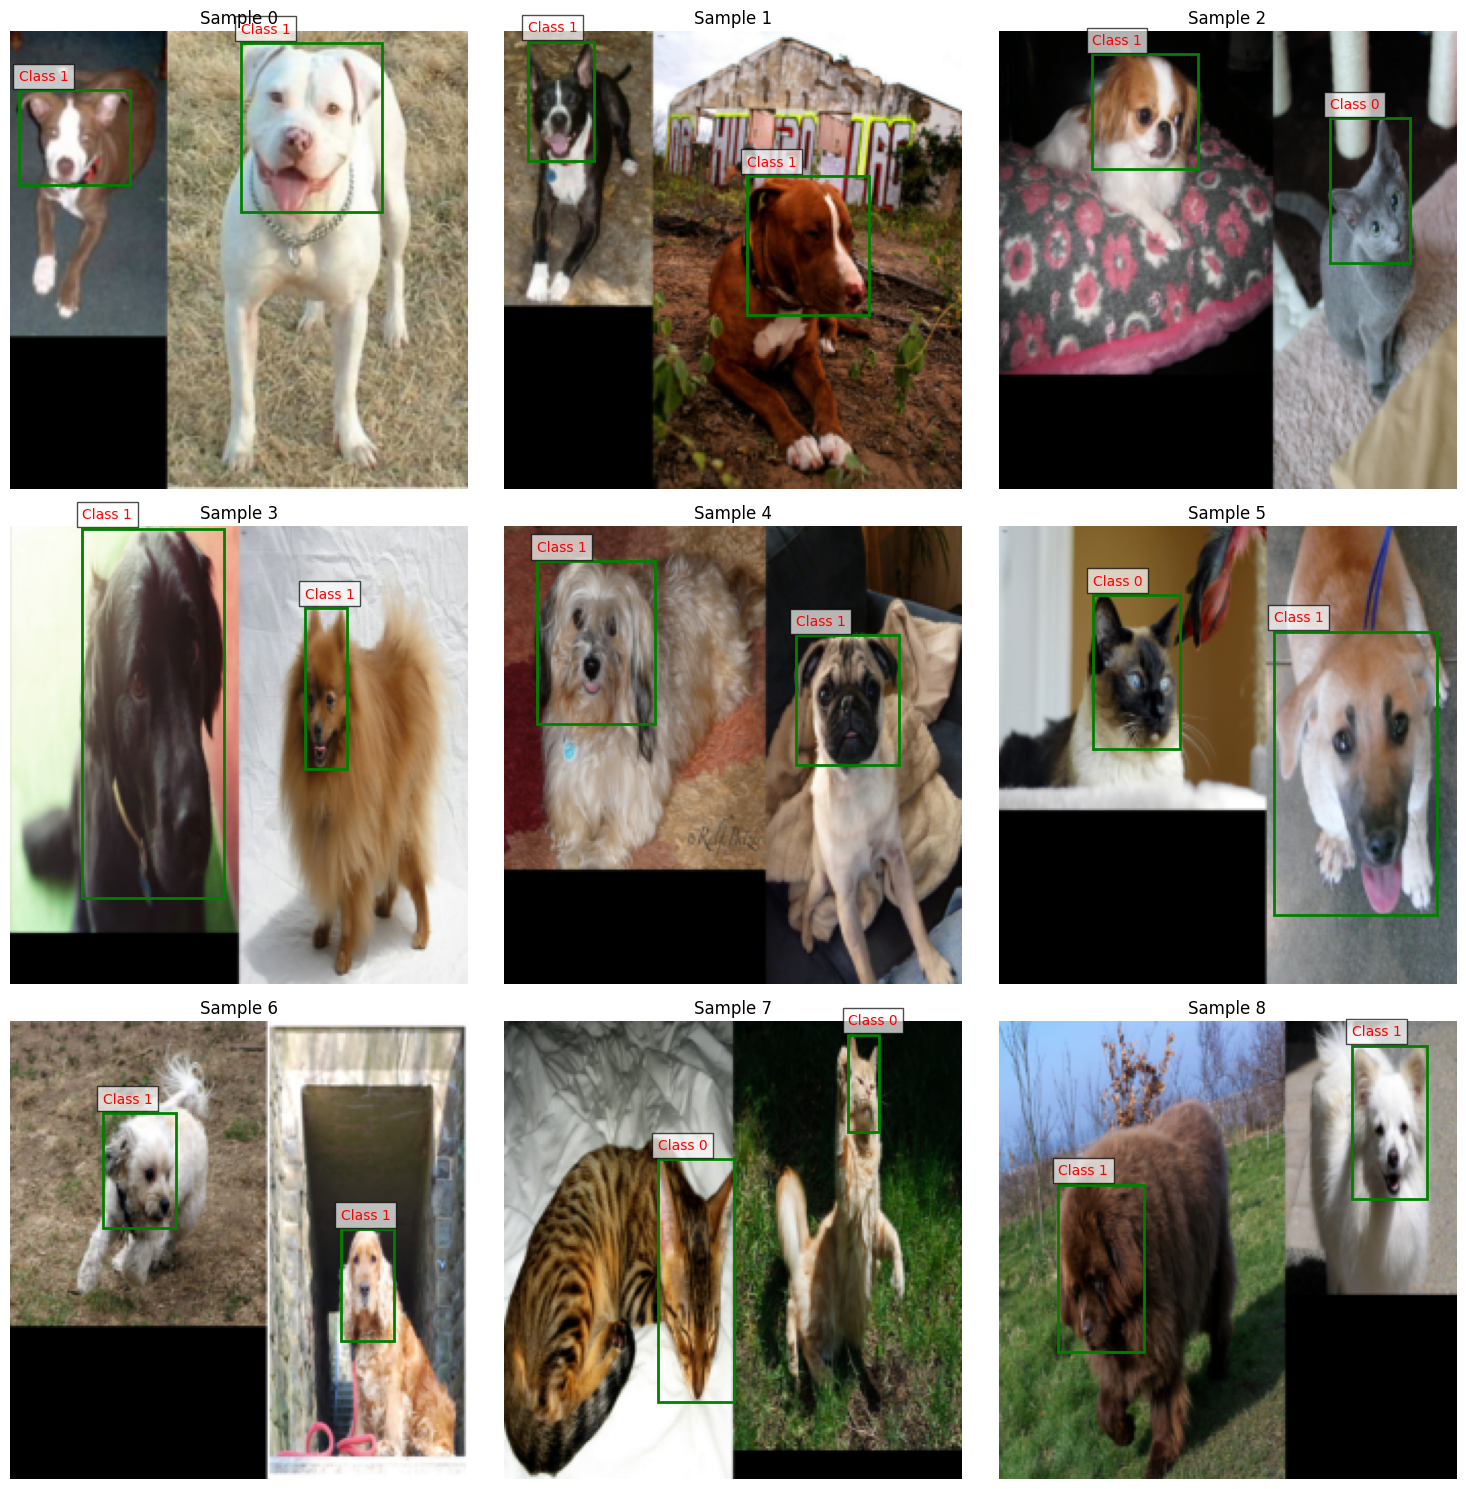

In [11]:
def visualize_data_samples(dataset, num_rows=3, num_cols=3, start_idx=0, class_to_idx=None):
    """Visualize samples from dataset with bounding boxes and labels

    Args:
        dataset: Dataset to visualize
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid
        start_idx: Starting index in dataset
        class_to_idx: Dictionary mapping class names to indices
    """

    # Add denormalization transform
    denorm = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        merged_image, annotations = dataset[start_idx + idx]

        # Denormalize the image before converting to PIL
        if isinstance(merged_image, torch.Tensor):
            merged_image = denorm(merged_image)
            # Clamp values to [0, 1] range
            merged_image = torch.clamp(merged_image, 0, 1)
            image = transforms.ToPILImage()(merged_image)
        else:
            image = merged_image

        ax.imshow(image)

        # Draw each bounding box on the image

        # Draw each bounding box on the image
        for ann in annotations:
            bbox = ann[:4]
            label = int(ann[4].item())

            # Scale bounding box coordinates to image size
            width, height = image.size
            x_min = bbox[0] * width
            y_min = bbox[1] * height
            x_max = bbox[2] * width
            y_max = bbox[3] * height

            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label text if class_to_idx is provided
            if class_to_idx:
                label_name = class_to_idx.get(label, f"Class {label}") 
                ax.text(
                    x_min,
                    y_min - 5,
                    label_name,
                    color="r",
                    fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.7),
                )

        ax.set_title(f"Sample {start_idx + idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Plot first grid (images 0-8)
visualize_data_samples(val_dataset, start_idx=0, class_to_idx=class_to_idx)

In [12]:
model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Train the model
num_epochs = 100
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.7490, Validation Loss: 2.0952, Validation mAP: 0.0017


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 0.9759, Validation Loss: 1.1166, Validation mAP: 0.0190


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 0.7289, Validation Loss: 1.0803, Validation mAP: 0.0241


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 0.6588, Validation Loss: 1.0367, Validation mAP: 0.0030


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 0.5355, Validation Loss: 1.7608, Validation mAP: 0.0244


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 0.5462, Validation Loss: 0.8532, Validation mAP: 0.0225


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 0.5550, Validation Loss: 0.7876, Validation mAP: 0.0523


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 0.4293, Validation Loss: 0.7597, Validation mAP: 0.0747


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 0.4548, Validation Loss: 4.1651, Validation mAP: 0.0495


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.5048, Validation Loss: 0.5994, Validation mAP: 0.0390


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 0.3855, Validation Loss: 0.6429, Validation mAP: 0.0518


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 0.4100, Validation Loss: 1.4562, Validation mAP: 0.0478


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 0.3966, Validation Loss: 0.6634, Validation mAP: 0.0848


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 0.3473, Validation Loss: 0.7056, Validation mAP: 0.0262


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 0.4344, Validation Loss: 0.8163, Validation mAP: 0.0101


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 0.4433, Validation Loss: 0.7217, Validation mAP: 0.0907


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 0.3834, Validation Loss: 0.7385, Validation mAP: 0.0843


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 0.3603, Validation Loss: 0.7515, Validation mAP: 0.1010


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 0.3806, Validation Loss: 0.7594, Validation mAP: 0.0444


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 0.4115, Validation Loss: 0.8585, Validation mAP: 0.0627


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 0.3488, Validation Loss: 0.8109, Validation mAP: 0.1210


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 0.4009, Validation Loss: 0.8259, Validation mAP: 0.0721


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 0.3674, Validation Loss: 0.7523, Validation mAP: 0.0664


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 0.3671, Validation Loss: 1.5076, Validation mAP: 0.0761


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 0.3545, Validation Loss: 0.9092, Validation mAP: 0.1194


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 0.3308, Validation Loss: 0.7919, Validation mAP: 0.0961


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 0.3419, Validation Loss: 1.0157, Validation mAP: 0.0381


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 0.3986, Validation Loss: 0.8873, Validation mAP: 0.0629


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 0.3324, Validation Loss: 0.7361, Validation mAP: 0.1048


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 0.3610, Validation Loss: 0.6278, Validation mAP: 0.1079


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 0.3059, Validation Loss: 0.5525, Validation mAP: 0.1343


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 0.2874, Validation Loss: 0.5502, Validation mAP: 0.0759


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 0.2892, Validation Loss: 0.7227, Validation mAP: 0.0779


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 0.3241, Validation Loss: 0.6693, Validation mAP: 0.1267


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 0.3194, Validation Loss: 0.6317, Validation mAP: 0.0622


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 0.2922, Validation Loss: 0.5889, Validation mAP: 0.1284


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 0.2835, Validation Loss: 0.7342, Validation mAP: 0.1401


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 0.3113, Validation Loss: 0.7009, Validation mAP: 0.1044


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 0.3049, Validation Loss: 0.8650, Validation mAP: 0.1207


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 0.2829, Validation Loss: 0.5744, Validation mAP: 0.1116


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 0.2724, Validation Loss: 0.5708, Validation mAP: 0.1370


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 0.2837, Validation Loss: 0.9481, Validation mAP: 0.0856


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 0.3709, Validation Loss: 1.2076, Validation mAP: 0.0764


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 0.3863, Validation Loss: 1.0529, Validation mAP: 0.0792


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 0.4318, Validation Loss: 1.4485, Validation mAP: 0.0452


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 0.3401, Validation Loss: 0.6187, Validation mAP: 0.1374


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 0.2986, Validation Loss: 0.7923, Validation mAP: 0.1276


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 0.2860, Validation Loss: 0.6143, Validation mAP: 0.1246


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 0.2801, Validation Loss: 0.6067, Validation mAP: 0.0819


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 0.2802, Validation Loss: 0.6295, Validation mAP: 0.1629


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 0.2672, Validation Loss: 0.5755, Validation mAP: 0.1812


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 0.2670, Validation Loss: 0.5468, Validation mAP: 0.1626


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 0.2637, Validation Loss: 0.5328, Validation mAP: 0.1872


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 54/100, Train Loss: 0.2619, Validation Loss: 0.5336, Validation mAP: 0.1790


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 55/100, Train Loss: 0.2611, Validation Loss: 0.5358, Validation mAP: 0.1818


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 56/100, Train Loss: 0.2603, Validation Loss: 0.5315, Validation mAP: 0.1909


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 57/100, Train Loss: 0.2598, Validation Loss: 0.5337, Validation mAP: 0.2026


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 58/100, Train Loss: 0.2593, Validation Loss: 0.5335, Validation mAP: 0.1815


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 59/100, Train Loss: 0.2582, Validation Loss: 0.5351, Validation mAP: 0.1932


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 60/100, Train Loss: 0.2596, Validation Loss: 0.5263, Validation mAP: 0.1852


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 61/100, Train Loss: 0.2598, Validation Loss: 0.5319, Validation mAP: 0.1788


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 62/100, Train Loss: 0.2593, Validation Loss: 0.5261, Validation mAP: 0.1700


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 63/100, Train Loss: 0.2585, Validation Loss: 0.5286, Validation mAP: 0.1948


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 64/100, Train Loss: 0.2578, Validation Loss: 0.5331, Validation mAP: 0.1486


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 65/100, Train Loss: 0.2579, Validation Loss: 0.5293, Validation mAP: 0.1854


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 66/100, Train Loss: 0.2574, Validation Loss: 0.5300, Validation mAP: 0.1964


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 67/100, Train Loss: 0.2573, Validation Loss: 0.5292, Validation mAP: 0.1901


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 68/100, Train Loss: 0.2574, Validation Loss: 0.5348, Validation mAP: 0.1902


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 69/100, Train Loss: 0.2576, Validation Loss: 0.5352, Validation mAP: 0.1962


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 70/100, Train Loss: 0.2577, Validation Loss: 0.5362, Validation mAP: 0.1763


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 71/100, Train Loss: 0.2567, Validation Loss: 0.5318, Validation mAP: 0.1915


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 72/100, Train Loss: 0.2574, Validation Loss: 0.5301, Validation mAP: 0.2006


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 73/100, Train Loss: 0.2573, Validation Loss: 0.5225, Validation mAP: 0.1886


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 74/100, Train Loss: 0.2574, Validation Loss: 0.5287, Validation mAP: 0.1913


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 75/100, Train Loss: 0.2571, Validation Loss: 0.5325, Validation mAP: 0.1897


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 76/100, Train Loss: 0.2569, Validation Loss: 0.5328, Validation mAP: 0.1909


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 77/100, Train Loss: 0.2565, Validation Loss: 0.5295, Validation mAP: 0.1566


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 78/100, Train Loss: 0.2565, Validation Loss: 0.5338, Validation mAP: 0.1650


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 79/100, Train Loss: 0.2563, Validation Loss: 0.5306, Validation mAP: 0.1841


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 80/100, Train Loss: 0.2566, Validation Loss: 0.5297, Validation mAP: 0.1662


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 81/100, Train Loss: 0.2565, Validation Loss: 0.5253, Validation mAP: 0.1926


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 82/100, Train Loss: 0.2562, Validation Loss: 0.5344, Validation mAP: 0.1637


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 83/100, Train Loss: 0.2567, Validation Loss: 0.5281, Validation mAP: 0.1837


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 84/100, Train Loss: 0.2568, Validation Loss: 0.5300, Validation mAP: 0.1945


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 85/100, Train Loss: 0.2564, Validation Loss: 0.5298, Validation mAP: 0.1957


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 86/100, Train Loss: 0.2562, Validation Loss: 0.5343, Validation mAP: 0.1798


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 87/100, Train Loss: 0.2560, Validation Loss: 0.5268, Validation mAP: 0.1982


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 88/100, Train Loss: 0.2559, Validation Loss: 0.5312, Validation mAP: 0.1994


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 89/100, Train Loss: 0.2559, Validation Loss: 0.5267, Validation mAP: 0.1785


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 90/100, Train Loss: 0.2561, Validation Loss: 0.5267, Validation mAP: 0.1751


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 91/100, Train Loss: 0.2560, Validation Loss: 0.5257, Validation mAP: 0.1775


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 92/100, Train Loss: 0.2561, Validation Loss: 0.5292, Validation mAP: 0.1867


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 93/100, Train Loss: 0.2565, Validation Loss: 0.5269, Validation mAP: 0.2029


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 94/100, Train Loss: 0.2565, Validation Loss: 0.5273, Validation mAP: 0.1102


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 95/100, Train Loss: 0.2564, Validation Loss: 0.5302, Validation mAP: 0.1844


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 96/100, Train Loss: 0.2562, Validation Loss: 0.5287, Validation mAP: 0.1909


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 97/100, Train Loss: 0.2560, Validation Loss: 0.5253, Validation mAP: 0.1706


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 98/100, Train Loss: 0.2559, Validation Loss: 0.5255, Validation mAP: 0.1971


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 99/100, Train Loss: 0.2560, Validation Loss: 0.5273, Validation mAP: 0.1828


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 100/100, Train Loss: 0.2562, Validation Loss: 0.5278, Validation mAP: 0.1545


## Inference

C:\Users\tienn\AppData\Local\Temp\ipykernel_19344\1879232138.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


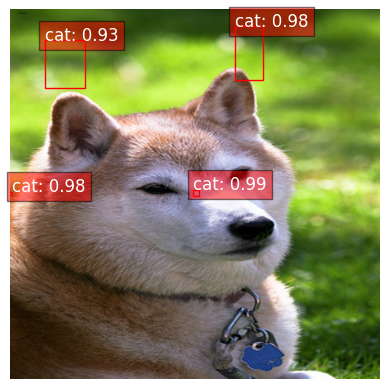

In [13]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the input size expected by the model (e.g., 448x448)
    resized_image = image.resize((448, 448))
    resized_width, resized_height = resized_image.size

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx))  # Reshape for 2x2 grid

    fig, ax = plt.subplots(1)
    ax.axis("off")
    ax.imshow(resized_image)  # Display resized image

    for grid_y in range(2):
        for grid_x in range(2):
            # Get the class prediction and bounding box for the current grid cell
            class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
            bbox = output[0, grid_y, grid_x, :4].tolist()  # Predicted bbox

            # Confidence (probability of the predicted class)
            confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[
                class_pred
                ].item()

            # Scale the bounding box back to the resized image size
            # Assuming bbox coordinates are normalized to [0, 1] within the grid cell
            x_min = bbox[0] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
            x_max = bbox[2] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

            # Draw the bounding box and label on the image if confidence is above threshold
            if confidence > threshold:
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                )
                ax.add_patch(rect)
                plt.text(
                    x_min,
                    y_min,
                    f"{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                    color="white",
                    fontsize=12,
                    bbox=dict(facecolor="red", alpha=0.5),
                )

    plt.show()

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Inference on a sample image
image_path = os.path.join(image_dir, "Cats_Test22.png")

inference(model, image_path, transform, device, class_to_idx, threshold=0.5)

### Visualize Prediction

In [21]:
def visualize_predictions(val_dataset, model, device, class_to_idx, num_rows=3, num_cols=3, start_idx=0):
    """Visualize model predictions vs ground truth on validation dataset

    Args:
        val_dataset: Validation dataset
        model: Trained model
        device: Device to run model on
        class_to_idx: Dictionary mapping class indices to class names
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid
        start_idx: Starting index in validation dataset
    """
    # Set model to evaluation mode
    model.eval()

    # Add denormalization transform
    denorm = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        # Get the image and ground truth annotations from the dataset
        image, ground_truth_annotations = val_dataset[start_idx + idx]

        # Move the image to the device and add a batch dimension
        input_image = image.unsqueeze(0).to(device)

        # Get model predictions
        with torch.no_grad():
            predictions = model(input_image)

        # Check if predictions are in the expected format
        if isinstance(predictions, list) and len(predictions) > 0:
            predictions = predictions[0]  # Get the first prediction in the batch
        else:
            # print(f"No predictions for sample {start_idx + idx}")
            predictions = {'boxes': torch.empty((0, 4)), 'labels': torch.empty((0,))}

        # Denormalize the image for visualization
        if isinstance(image, torch.Tensor):
            denorm_image = denorm(image)
            denorm_image = torch.clamp(denorm_image, 0, 1)
            image = transforms.ToPILImage()(denorm_image)

        # Display the image
        ax.imshow(image)

        # Draw ground truth bounding boxes
        for ann in ground_truth_annotations:
            bbox = ann[:4]
            label = int(ann[4].item())

            # Scale bounding box coordinates to image size
            width, height = image.size
            x_min = bbox[0] * width
            y_min = bbox[1] * height
            x_max = bbox[2] * width
            y_max = bbox[3] * height

            # Create a rectangle patch for ground truth
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",  # Green for ground truth
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label text for ground truth
            if class_to_idx:
                label_name = class_to_idx.get(label, f"Class {label}")
                ax.text(
                    x_min,
                    y_min - 5,
                    f"GT: {label_name}",
                    color="g",
                    fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.7),
                )

        # Draw predicted bounding boxes
        if 'boxes' in predictions and 'labels' in predictions:
            for bbox, label in zip(predictions['boxes'], predictions['labels']):
                bbox = bbox.cpu().numpy()
                label = int(label.item())

                # Scale bounding box coordinates to image size
                x_min, y_min, x_max, y_max = bbox
                width, height = image.size
                x_min *= width
                y_min *= height
                x_max *= width
                y_max *= height

                # Create a rectangle patch for predictions
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=2,
                    edgecolor="r",  # Red for predictions
                    facecolor="none",
                )
                ax.add_patch(rect)

                # Add label text for predictions
                if class_to_idx:
                    label_name = class_to_idx.get(label, f"Class {label}")
                    ax.text(
                        x_min,
                        y_min - 20,
                        f"Pred: {label_name}",
                        color="r",
                        fontsize=10,
                        bbox=dict(facecolor="white", alpha=0.7),
                    )

        ax.set_title(f"Sample {start_idx + idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

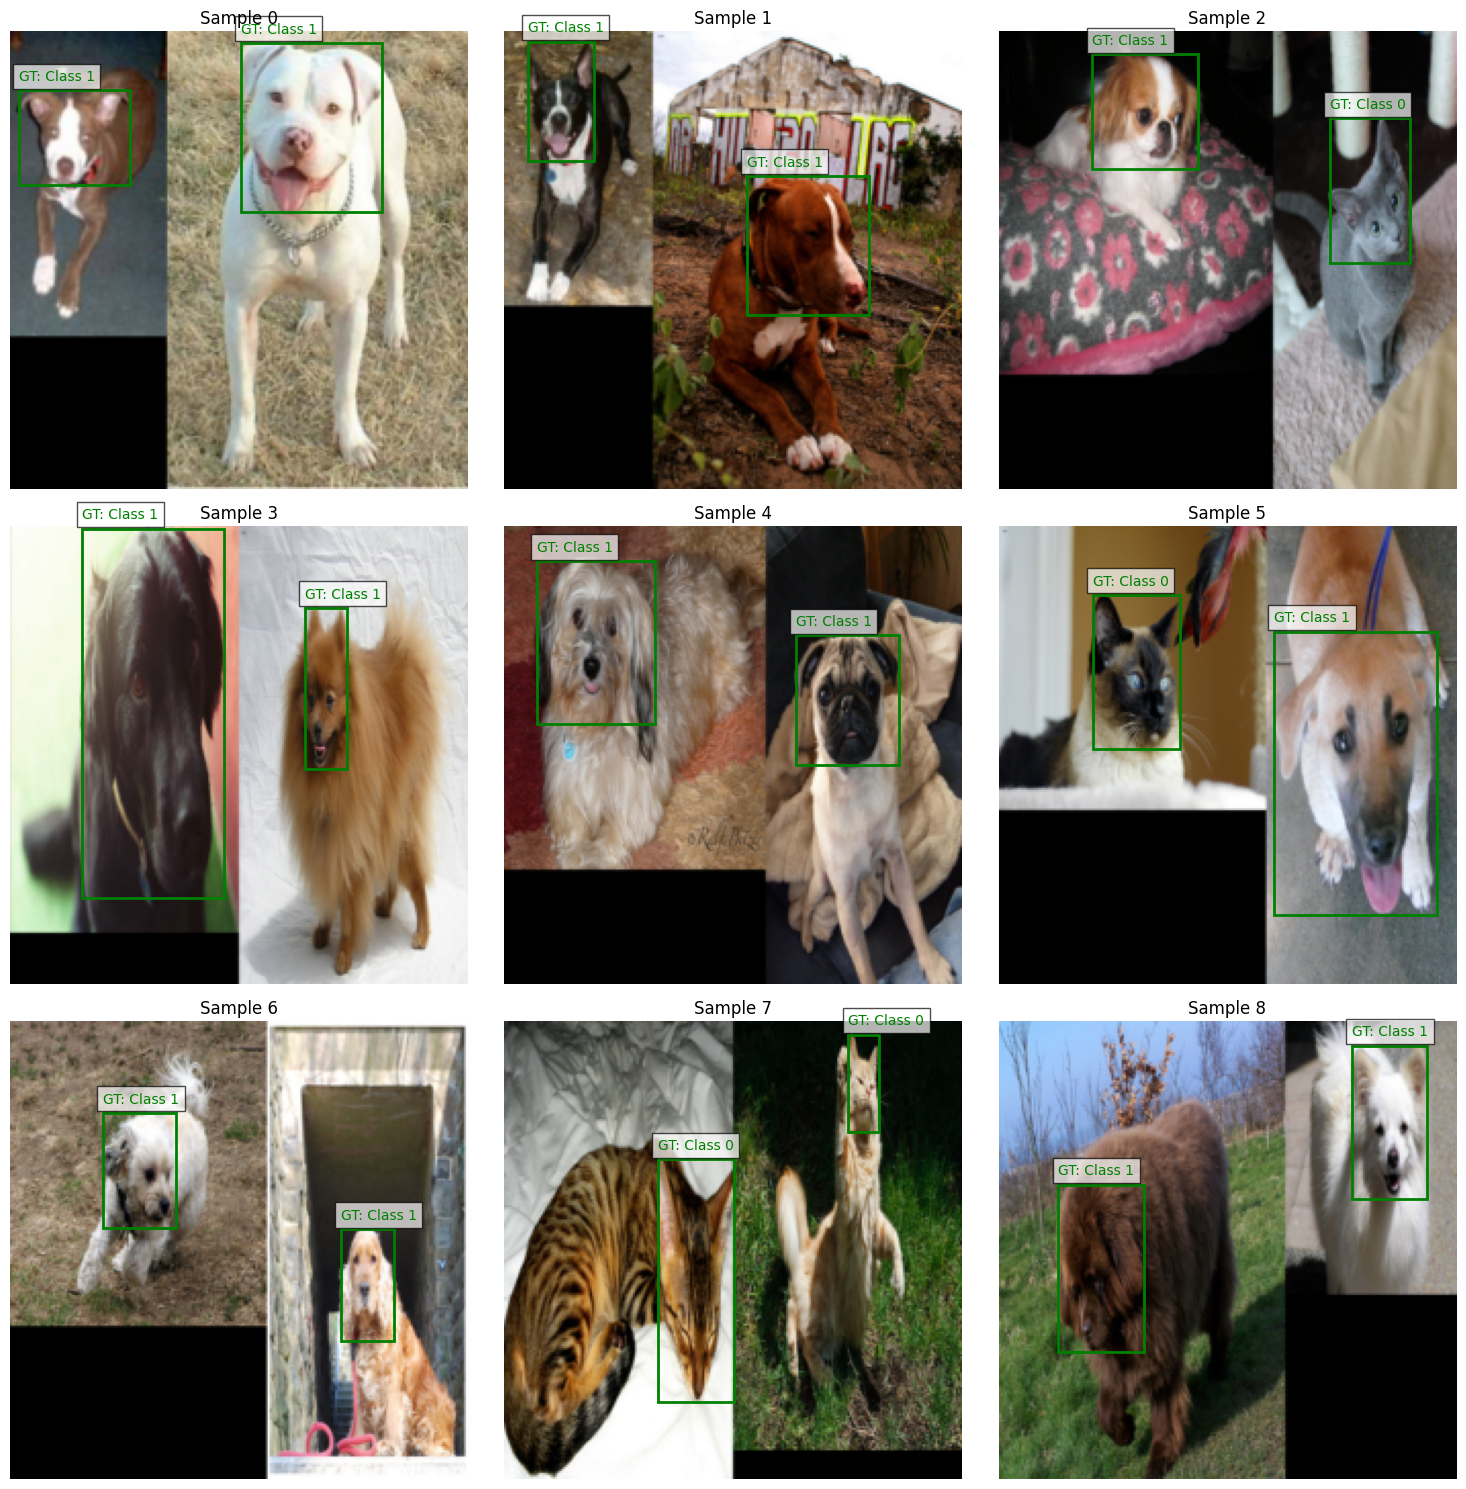

In [22]:
# Assuming val_dataset is a dataset object, model is a trained model, and class_to_idx is a dictionary
visualize_predictions(val_dataset, model, device, class_to_idx=class_to_idx, num_rows=3, num_cols=3, start_idx=0)